# BCI Giuseppe Bonomo BCI2b IV

In [1]:

#%%
#!git clone https://github.com/marco-siino/EEG-ATCNet.git
!git clone https://github.com/Bonomo31/Tesi.git
%pip install mne
%pip install PyWavelets
#Le ulitme versioni non sono compatibili con le librerie usate
#in preprocess_HGD.py, quindi si è optato a utilizzare una versione meno recente
#%pip install braindecode==0.3

import os
import sys
import shutil
import time
import pywt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.signal as signal


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
os.chdir("/content/Tesi/BCI2b_IV/")
#os.chdir("/Users/giuseppebonomo/Desktop/Tesi/BCI2b_IV/")
#os.chdir("/Users/Giuseppe/Desktop/Tesi/codice/Tesi/BCI2b_IV/")


import models

from preprocess import get_data
#from keras.utils.vis_utils import plot_model

fatal: destination path 'Tesi' already exists and is not an empty directory.


# Organize the dataset.

In [ ]:
"""import os
import requests
import zipfile

# Creare la cartella "dataset" se non è già presente
os.makedirs("dataset", exist_ok=True)

# Percorso del file GDF e ZIP
gdf_path = "/Users/Giuseppe/Desktop/Tesi/codice/Tesi/BCI2b_IV/dataset/B0101T.gdf"
zip_path = "dataset/BCI2b.zip"

# Scaricare il dataset nella cartella "dataset" se non è già presente
if not os.path.exists(gdf_path):
    url = "https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip"
    print("Scaricamento del dataset in corso...")

    # Scaricare il file ZIP
    response = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

    print("Estrazione dei file...")
    # Estrarre i file nella cartella "dataset"
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("dataset")

    # Rimuovere il file .zip
    os.remove(zip_path)
    print("Dataset scaricato ed estratto con successo.")
else:
    print("Dataset già scaricato.")"""

'import os\nimport requests\nimport zipfile\n\n# Creare la cartella "dataset" se non è già presente\nos.makedirs("dataset", exist_ok=True)\n\n# Percorso del file GDF e ZIP\ngdf_path = "/Users/Giuseppe/Desktop/Tesi/codice/Tesi/BCI2b_IV/dataset/B0101T.gdf"\nzip_path = "dataset/BCI2b.zip"\n\n# Scaricare il dataset nella cartella "dataset" se non è già presente\nif not os.path.exists(gdf_path):\n    url = "https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip"\n    print("Scaricamento del dataset in corso...")\n    \n    # Scaricare il file ZIP\n    response = requests.get(url)\n    with open(zip_path, "wb") as f:\n        f.write(response.content)\n    \n    print("Estrazione dei file...")\n    # Estrarre i file nella cartella "dataset"\n    with zipfile.ZipFile(zip_path, "r") as zip_ref:\n        zip_ref.extractall("dataset")\n    \n    # Rimuovere il file .zip\n    os.remove(zip_path)\n    print("Dataset scaricato ed estratto con successo.")\nelse:\n    print("Datase

In [2]:
# Creare la cartella "dataset" se non è già presente (MacOS)
os.makedirs("dataset", exist_ok=True)

# Scaricare il dataset nella cartella "dataset" se non è già presente
if not os.path.exists("dataset/B0101T.gdf"):
    !wget -O dataset/BCI2b.zip "https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip"

    # Estrarre i file nella cartella "dataset"
    !unzip dataset/BCI2b.zip -d dataset

    # Rimuovere il file .zip
    os.remove("dataset/BCI2b.zip")
else:
    print("Dataset già scaricato")

Dataset già scaricato


# Functions definitions

In [3]:
#%%
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

# Preprocessing functions definition

## DB4 (Soft -> Threshold 5.5)

In [4]:
def db4_soft(signal, wavelet='db4', level=4, threshold=5.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """


    print("Lunghezza originale:", signal.shape[-1])  # Dovrebbe essere 1125
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    print("Lunghezza coefficiente di approssimazione:", len(coeffs[0]))

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='per')
    print("Lunghezza ricostruita:", len(reconstructed_signal))

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


## DB4 (Hard -> Threshold 10.5)

In [5]:
def db4_hard(signal, wavelet='db4', level=4, threshold=10.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


## RDWT

In [6]:
def rational_dilated_wavelet_transform(sig, wavelet='db4', levels=4, dilation_factors=None, threshold=5.5):
    """
    Applica la Rational Dilated Wavelet Transform (RDWT) a un segnale EEG multidimensionale.

    Args:
    - sig: array numpy di forma (eventi, 1, canali, campioni)
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - levels: numero di livelli di decomposizione (default 4)
    - dilation_factors: lista di fattori di dilatazione razionale (default: [3/2, 5/3, 7/4, ...])
    - threshold: soglia per i coefficienti di dettaglio (default 5.5)

    Returns:
    - Segnale ricostruito con la RDWT (stessa dimensione dell'input)
    """
    eventi, _, canali, campioni = sig.shape
    print("Lunghezza originale del segnale:", sig.shape)

    if dilation_factors is None:
        dilation_factors = [3/2, 5/3, 7/4, 9/5]

    coeffs_approx = sig.copy()  # Inizializza con il segnale originale
    detail_coeffs = []

    for i in range(levels):
        factor = dilation_factors[i]
        wavelet_filter = pywt.Wavelet(wavelet)
        lo_d, hi_d = wavelet_filter.dec_lo, wavelet_filter.dec_hi

        # Ridimensionamento dei filtri
        lo_d = signal.resample(lo_d, int(len(lo_d) * factor))
        hi_d = signal.resample(hi_d, int(len(hi_d) * factor))

        print(f"Livello {i+1}: coeffs_approx shape {coeffs_approx.shape}, lo_d shape {lo_d.shape}, hi_d shape {hi_d.shape}")

        approx = np.zeros_like(coeffs_approx)
        detail = np.zeros_like(coeffs_approx)

        # Applica la convoluzione per ogni canale EEG
        for e in range(eventi):
            for c in range(canali):
                approx[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], lo_d, mode='same')
                detail[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], hi_d, mode='same')

                # Soglia sui coefficienti di dettaglio
                detail[e, 0, c, np.abs(detail[e, 0, c, :]) < threshold] = 0

        detail_coeffs.append(detail)
        coeffs_approx = approx  # Passa l'approssimazione al livello successivo

    # Ricostruzione del segnale
    reconstructed = coeffs_approx.copy()
    for i in range(levels-1, -1, -1):
        reconstructed += detail_coeffs[i]

    print("Lunghezza del segnale ricostruito:", reconstructed.shape)
    return reconstructed

# RDWT normalized with min-max

In [7]:
def normalize_min_max(sig, reconstructed):
    """
    Normalizza il segnale ricostruito usando la normalizzazione Min-Max,
    riportandolo alla scala del segnale di input.

    Args:
    - sig: array numpy di forma (eventi, 1, canali, campioni), segnale di input
    - reconstructed: array numpy di forma (eventi, 1, canali, campioni), segnale ricostruito

    Returns:
    - Segnale ricostruito normalizzato sulla scala dell'input
    """
    min_input = np.min(sig, axis=-1, keepdims=True)
    max_input = np.max(sig, axis=-1, keepdims=True)

    min_reconstructed = np.min(reconstructed, axis=-1, keepdims=True)
    max_reconstructed = np.max(reconstructed, axis=-1, keepdims=True)

    # Evita la divisione per zero
    range_reconstructed = max_reconstructed - min_reconstructed
    range_reconstructed[range_reconstructed == 0] = 1

    normalized = (reconstructed - min_reconstructed) / range_reconstructed

    # Riporta alla scala originale
    scaled = normalized * (max_input - min_input) + min_input

    return scaled

# Apply Preprocessing

In [8]:
def apply_preprocessing (signals_data, preprocessing):
  if preprocessing=="none":
    return signals_data
  elif preprocessing=="db4_soft":
    return db4_soft(signals_data)
  elif preprocessing=="db4_hard":
    return db4_hard(signals_data)
  elif preprocessing=="rdwt":
    return rational_dilated_wavelet_transform(signals_data)
  elif preprocessing=="rdwt_normalized":
    reconstructed = rational_dilated_wavelet_transform(signals_data)
    return normalize_min_max(signals_data, reconstructed)


# Model training function

In [9]:
#%% Training
def train(dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models RockNetY.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log RockNetY.txt", "w")

    # Get dataset parameters
    dataset = dataset_conf.get('name')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and validation data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)


        print("\n\nBefore preprocessing X_train shape is:"+str(X_train.shape))
        print("Before preprocessing X_val shape is:"+str(X_val.shape))

        X_train = apply_preprocessing(X_train, preprocessing=signal_preprocessing)
        X_val = apply_preprocessing(X_val, preprocessing=signal_preprocessing)

        print("\n\nAfter preprocessing X_train shape is:"+str(X_train.shape))
        print("After preprocessing X_val shape is:"+str(X_val.shape))


        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.weights.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()


# Evaluation function

In [10]:
#%% Evaluation
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log RockNetY.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
    #Ripetuto
    #signal_preprocessing = dataset_conf.get('signal_preprocessing')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        X_test = apply_preprocessing(X_test, preprocessing=signal_preprocessing)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.weights.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()

# Model selection and setup

In [11]:
#%%
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'RockNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.RockNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'RockNetA'):
        model = models.RockNetA(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetB'):
        model = models.RockNetB(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetC'):
        model = models.RockNetC(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetX'):
        model = models.RockNetX(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'transformer',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 3,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='gelu',
        )
    elif(model_name == 'RockNetY'):
        model = models.RockNetY(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
        )
    elif(model_name == 'RockNetZ'):
        model = models.RockNetZ(
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            n_windows = 5,
            attention = 'mha',
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='relu',
        )
    elif(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

# Run the simulation

## Define the run function.

In [12]:
#%%
def run(signal_preprocessing):
    # Define dataset parameters
    #dataset = 'BCI2a' # Options: 'BCI2a','BCI2b','HGD'
    dataset = 'BCI2b'

    if dataset == 'BCI2a':
        in_samples = 1125
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
        data_path = 'dataset/' #os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    elif dataset == 'HGD':
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
        data_path = 'dataset/' #os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
    elif dataset == 'BCI2b':
        in_samples = 750
        n_channels = 3
        n_sub = 9
        n_classes = 2
        classes_labels = ['Left hand', 'Right hand']
        data_path = 'dataset/' #os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2b/BCI Competition IV 2b.mat'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/results_RockNetY"
    if not  os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist

    # Set dataset paramters
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False,
                     'signal_preprocessing':signal_preprocessing}

    # Set training hyperparamters
    #AUMENTARE LE EPOCHE A 1000
    train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'RockNetY'}

    # Train the model
    print("Training the model...")
    train(dataset_conf, train_conf, results_path)
    print("Training completed!")

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
    test(model, dataset_conf, results_path)


## No preprocessing on EEG.

In [ ]:
run("none")

##  DB4 (Soft) Preprocessing.

In [ ]:
run("db4_soft")

## DB4 (Hard) Preprocessing.

In [ ]:
run("db4_hard")

## RDWT

Training the model...

Training on subject  1
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0102T.gdf...
GDF

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0103T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4,

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0104E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0105E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (84, 2)
y_test_onehot shape: (94, 2)


Before preprocessing X_train shape is:(67, 1, 3, 750)
Before preprocessing 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (17, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 1   seed 1   time: 8.3 m   valid_acc: 0.8235   valid_loss: 0.813
Plot Learning Curves ....... 


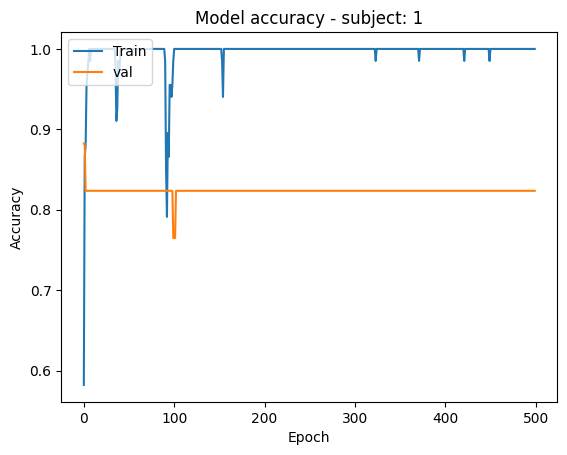

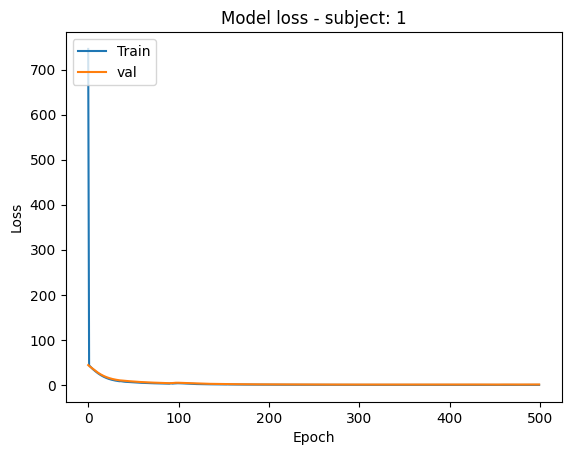


Training on subject  2
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0201T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0202T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0203T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0204E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0205E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (74, 2)
y_test_onehot shape: (37, 2)


Before preprocessing X_train shape is:(59, 1, 3, 750)
Before preprocessing 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (15, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 2   seed 1   time: 9.9 m   valid_acc: 1.0000   valid_loss: 0.530
Plot Learning Curves ....... 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


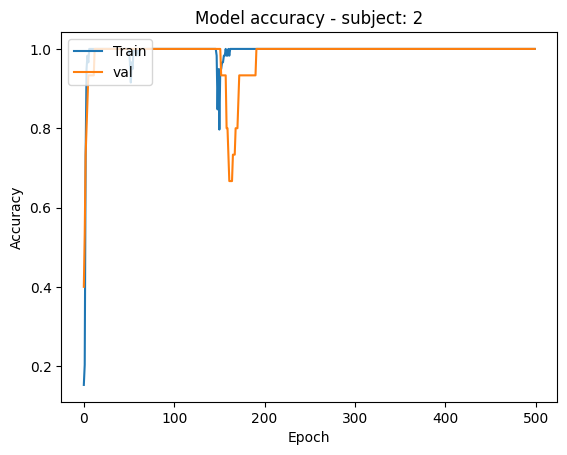

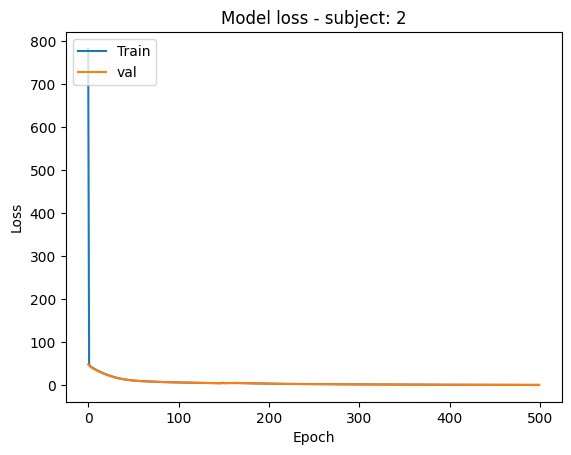


Training on subject  3
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0301T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0302T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0303T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0304E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0305E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (107, 2)
y_test_onehot shape: (92, 2)


Before preprocessing X_train shape is:(85, 1, 3, 750)
Before preprocessing

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (22, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 3   seed 1   time: 9.9 m   valid_acc: 0.9545   valid_loss: 0.382
Plot Learning Curves ....... 


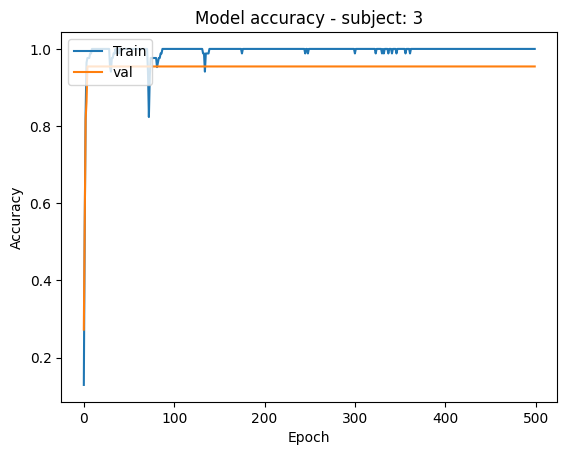

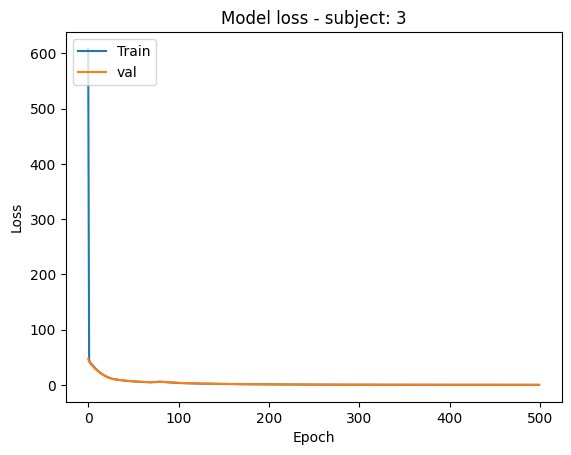


Training on subject  4
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0401T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0402T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0403T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0404E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0405E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (24, 2)
y_test_onehot shape: (15, 2)


Before preprocessing X_train shape is:(19, 1, 3, 750)
Before preprocessing 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (5, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 4   seed 1   time: 9.5 m   valid_acc: 1.0000   valid_loss: 0.669
Plot Learning Curves ....... 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


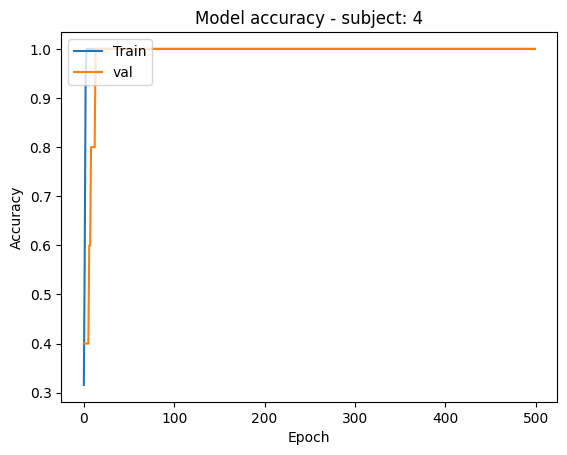

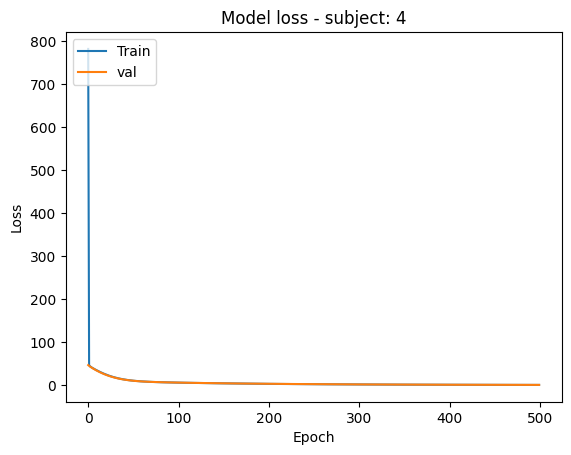


Training on subject  5
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0501T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0502T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0503T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0504E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0505E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4,

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (41, 2)
y_test_onehot shape: (52, 2)


Before preprocessing X_train shape is:(32, 1, 3, 750)
Before preprocessing 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (9, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 5   seed 1   time: 9.4 m   valid_acc: 0.8889   valid_loss: 1.073
Plot Learning Curves ....... 


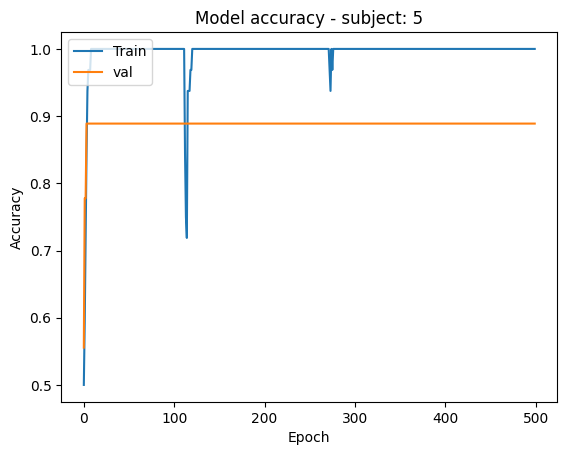

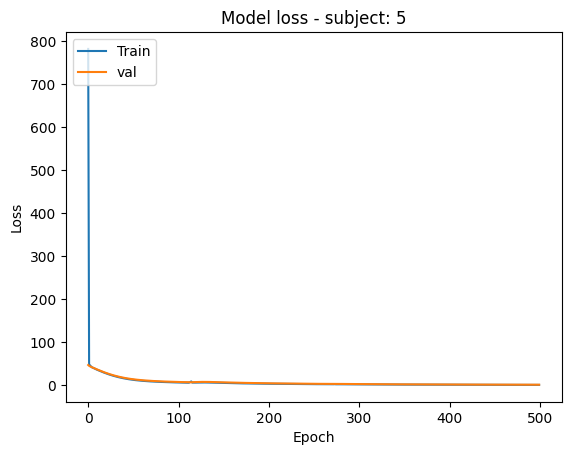


Training on subject  6
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0601T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0602T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0603T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0604E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0605E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (108, 2)
y_test_onehot shape: (71, 2)


Before preprocessing X_train shape is:(86, 1, 3, 750)
Before preprocessing

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (22, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 6   seed 1   time: 9.5 m   valid_acc: 0.9091   valid_loss: 0.768
Plot Learning Curves ....... 


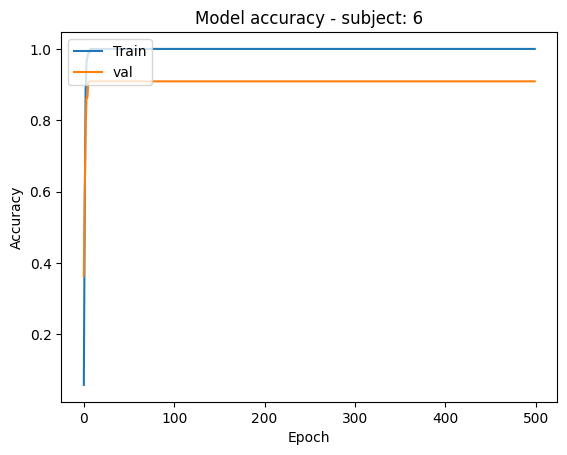

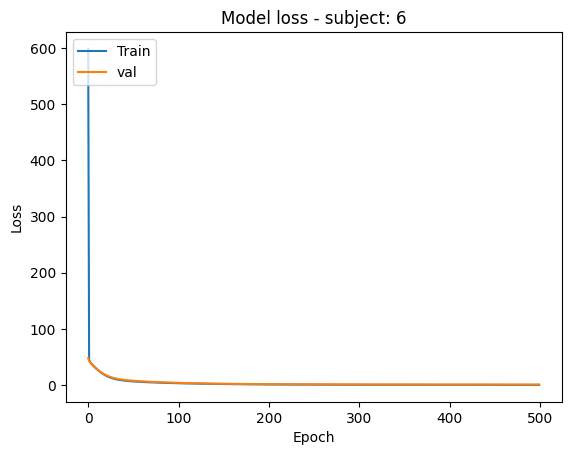


Training on subject  7
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0701T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0702T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0703T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0704E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0705E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (47, 2)
y_test_onehot shape: (90, 2)


Before preprocessing X_train shape is:(37, 1, 3, 750)
Before preprocessing 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 7   seed 1   time: 8.3 m   valid_acc: 0.8000   valid_loss: 1.668
Plot Learning Curves ....... 


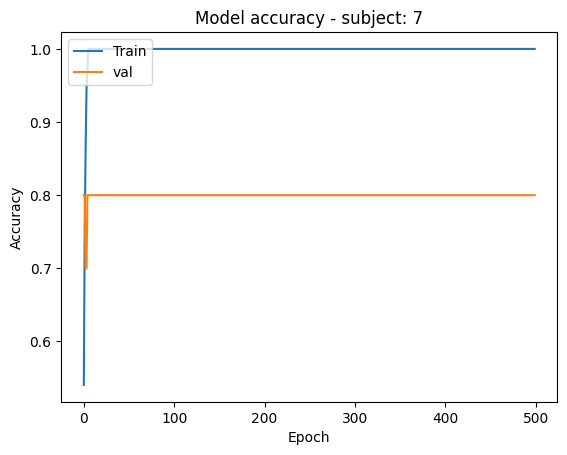

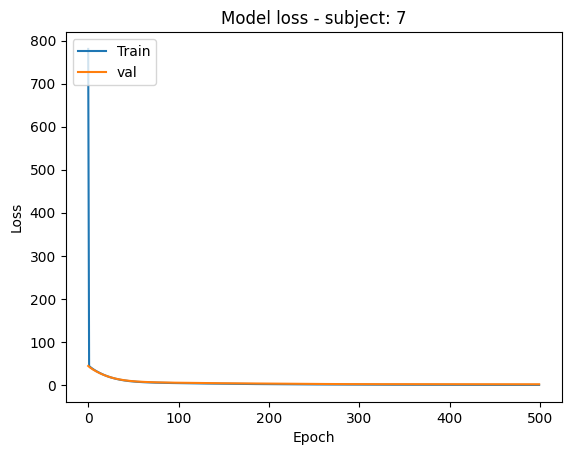


Training on subject  8
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0801T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 787728  =      0.000 ...  3150.912 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0802T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0803T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0804E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0805E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (115, 2)
y_test_onehot shape: (92, 2)


Before preprocessing X_train shape is:(92, 1, 3, 750)
Before preprocessing

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (23, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 8   seed 1   time: 10.8 m   valid_acc: 1.0000   valid_loss: 0.073
Plot Learning Curves ....... 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


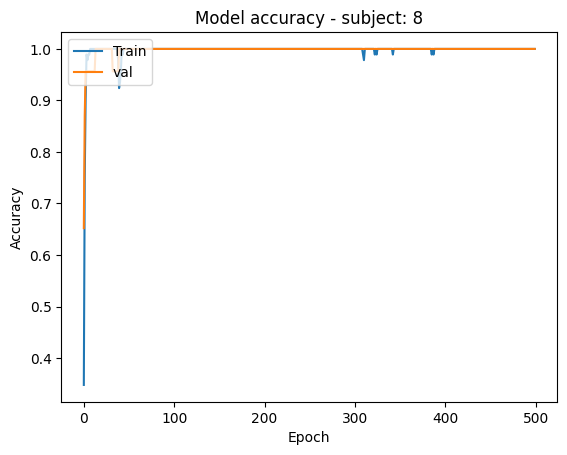

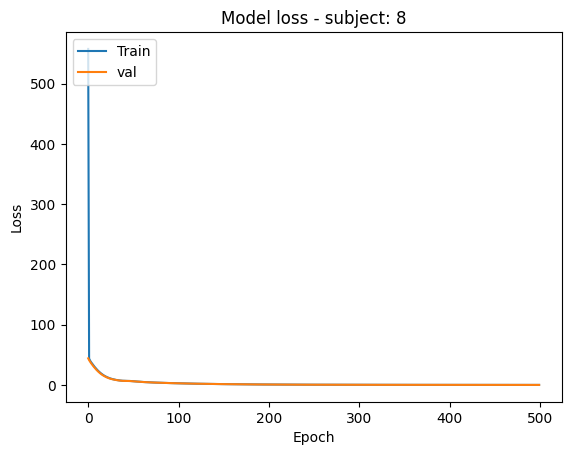


Training on subject  9
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0901T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0902T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0903T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0904E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0905E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (86, 2)
y_test_onehot shape: (77, 2)


Before preprocessing X_train shape is:(68, 1, 3, 750)
Before preprocessing 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (18, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Subject: 9   seed 1   time: 9.2 m   valid_acc: 0.9444   valid_loss: 0.104
Plot Learning Curves ....... 


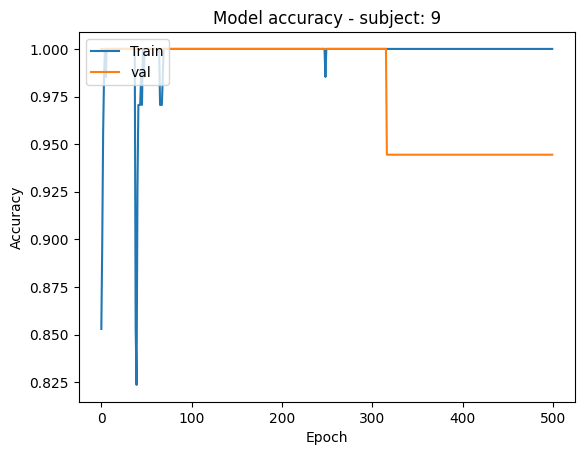

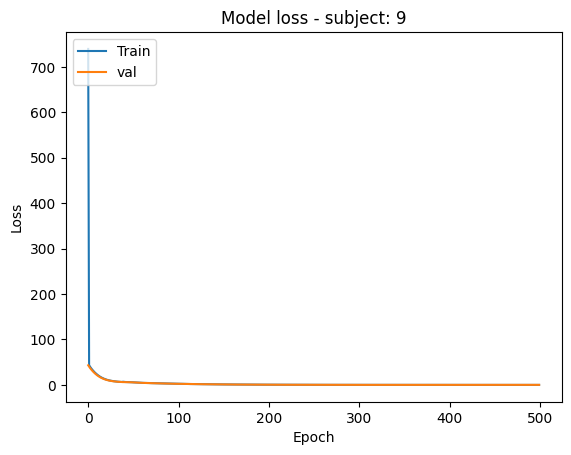


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  82.35   100.00   95.45   100.00   88.89   90.91   80.00   100.00   94.44     92.45   
---------------------------------
Average acc - all seeds: 92.45 %

Train Time  - all seeds: 85.7 min
---------------------------------

Training completed!
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0102T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0103T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4,

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0104E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0105E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (84, 2)
y_test_onehot shape: (94, 2)
Lunghezza originale del segnale: (94, 1, 3, 750)
Livello 1: coeffs_approx sha

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0201T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0202T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0203T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0204E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0205E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (74, 2)
y_test_onehot shape: (37, 2)
Lunghezza originale del segnale: (37, 1, 3, 750)
Livello 1: coeffs_approx sha

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0302T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0303T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0304E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0305E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (107, 2)
y_test_onehot shape: (92, 2)
Lunghezza originale del segnale: (92, 1, 3, 750)
Livello 1: coeffs_approx sh

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0402T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0403T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0404E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0405E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (24, 2)
y_test_onehot shape: (15, 2)
Lunghezza originale del segnale: (15, 1, 3, 750)
Livello 1: coeffs_approx sha

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0502T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0503T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0504E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0505E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4,

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (41, 2)
y_test_onehot shape: (52, 2)
Lunghezza originale del segnale: (52, 1, 3, 750)
Livello 1: coeffs_approx sha

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0602T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0603T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0604E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0605E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (108, 2)
y_test_onehot shape: (71, 2)
Lunghezza originale del segnale: (71, 1, 3, 750)
Livello 1: coeffs_approx sh

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0702T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0703T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0704E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0705E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (47, 2)
y_test_onehot shape: (90, 2)
Lunghezza originale del segnale: (90, 1, 3, 750)
Livello 1: coeffs_approx sha

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0802T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0803T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0804E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0805E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (115, 2)
y_test_onehot shape: (92, 2)
Lunghezza originale del segnale: (92, 1, 3, 750)
Livello 1: coeffs_approx sh

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0902T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0903T.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('781')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0904E.gdf...
GDF file detected
Setting channel info struc

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Extracting EDF parameters from /content/Tesi/BCI2b_IV/dataset/B0905E.gdf...
GDF file detected
Setting channel info structure...
Could no

/content/Tesi/BCI2b_IV/preprocess.py:87: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(gdf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
y_train_onehot shape: (86, 2)
y_test_onehot shape: (77, 2)
Lunghezza originale del segnale: (77, 1, 3, 750)
Livello 1: coeffs_approx sha

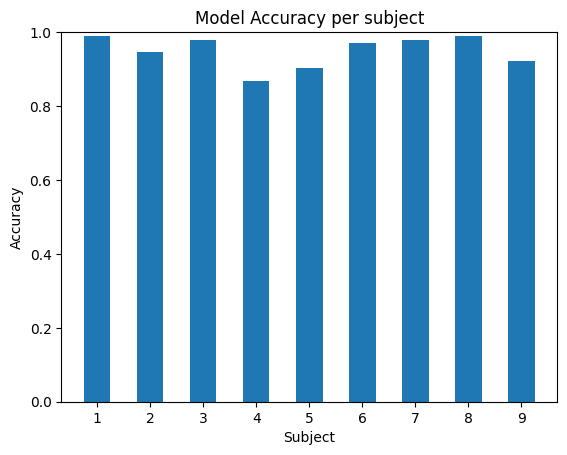

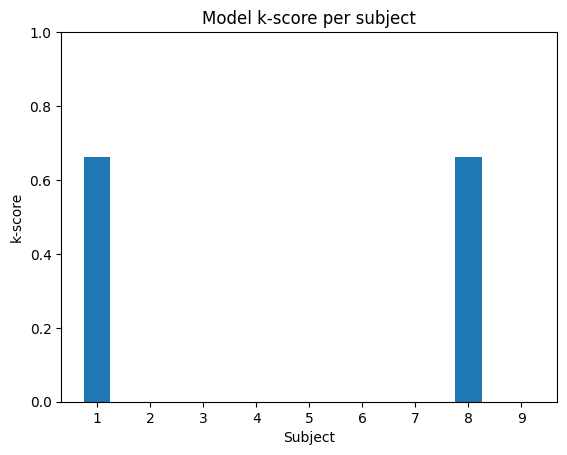

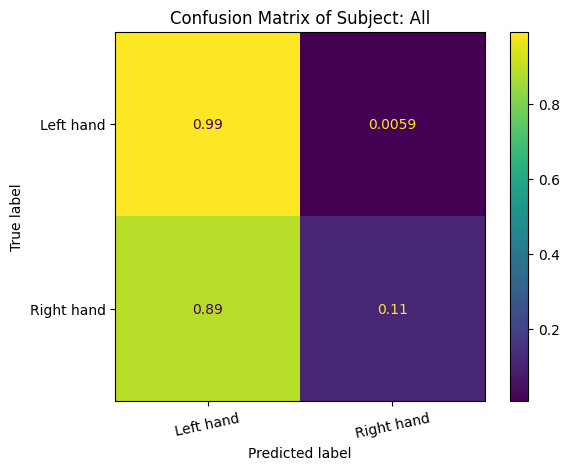

In [13]:
run("rdwt")

## RDWT Normalized

In [ ]:
run("rdwt_normalized")